In [1]:
import cx_Oracle
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import re
from matplotlib import rc
rc("font", family = "Malgun Gothic")
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, r2_score
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve
from sklearn.metrics import mean_squared_error, mean_squared_log_error 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn import tree
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier
from lightgbm import plot_importance
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score


import warnings
warnings.filterwarnings("ignore")

In [2]:
def visualize_silhouette(cluster_lists, X_features): 
    
    from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math
    
    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)
        
        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)
        
        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        
        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()
            
            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
            
        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

In [3]:
def visualize_kmeans_plot_multi(cluster_lists, X_features):
    
    from sklearn.cluster import KMeans
    from sklearn.decomposition import PCA
    import pandas as pd
    import numpy as np
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 만큼의 sub figures를 가지는 axs 생성 
    n_cols = len(cluster_lists)
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 입력 데이터의 FEATURE가 여러개일 경우 2차원 데이터 시각화가 어려우므로 PCA 변환하여 2차원 시각화
    pca = PCA(n_components=2)
    pca_transformed = pca.fit_transform(X_features)
    dataframe = pd.DataFrame(pca_transformed, columns=['PCA1','PCA2'])
    
     # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 KMeans 클러스터링 수행하고 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링으로 클러스터링 결과를 dataframe에 저장. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(pca_transformed)
        dataframe['cluster']=cluster_labels
        
        unique_labels = np.unique(clusterer.labels_)
        markers=['o', 's', '^', 'x', '*']
       
        # 클러스터링 결과값 별로 scatter plot 으로 시각화
        for label in unique_labels:
            label_df = dataframe[dataframe['cluster']==label]
            if label == -1:
                cluster_legend = 'Noise'
            else :
                cluster_legend = 'Cluster '+str(label) 
            marker_idx = label % len(markers)
            axs[ind].scatter(x=label_df['PCA1'], y=label_df['PCA2'], s=70,\
                        edgecolor='k', marker=markers[marker_idx], label=cluster_legend)

        axs[ind].set_title('Number of Cluster : '+ str(n_cluster))    
        #axs[ind].legend(loc='upper right')
    
    plt.show()

In [4]:
def get_age(x):
    cat = ''
    if x == "19세 이하" or x == "20세~24세": cat = "학생층"
    elif x == "25세~29세" or x == "30세~34세": cat = "청년층"
    elif x == "35세~39세" or x == "40세~44세": cat = "중년층"
    elif x == "45세~49세" or x == "50세~54세": cat = "장년층"
    else : cat = "노년층"
    
    return cat

def get_region(x):
    cat = ''
    if x == "110": cat = "경기"
    elif x == "210": cat = "인천"
    elif x == "240": cat = "강원"
    elif x == "270": cat = "충북"
    elif x == "300": cat = "세종"
    elif x == "310": cat = "충남"
    elif x == "340": cat = "대전"
    elif x == "360": cat = "경북"
    elif x == "410": cat = "대구"
    elif x == "440": cat = "울산"
    elif x == "460": cat = "부산"
    elif x == "500": cat = "경남"
    elif x == "540": cat = "전북"
    elif x == "570": cat = "전남"
    elif x == "610": cat = "광주"
    elif x == "630": cat = "제주"
    else : cat = "서울"
    
    return cat

In [5]:
def get_AB(x):
    cat = ''
    if np.isnan(x):
        cat = 0
    else:
        cat = 1

    return cat

In [6]:
clusterdata = pd.read_pickle("dataSet/clusterdata.pkl")
customerdata = pd.read_pickle("dataSet/customerdata.pkl")
customerdata

,고객번호,성별,연령대,거주지역,A선호점포,B선호점포,C선호점포,D선호점포,선호제휴사,선호점포,...,15_3분기,15_4분기,최근성,행동 빈도,구매 총액,평균구매액,최대값1,최대값2,최대값3,LABEL
0,00001,M,60세이상,060,12.0,13.0,96.0,NaN,A,12,...,7806580.0,5295938.0,2,1057,85042550,80456.53,디지털,가구,기타,1
1,00002,M,60세이상,100,7.0,18.0,NaN,33.0,A,7,...,13842600.0,12001220.0,2,1116,99880760,89498.89,일상,전문스포츠,디지털,1
2,00003,M,60세이상,033,1.0,9.0,34.0,NaN,C,34,...,421017.0,258101.0,4,1191,3165167,2657.57,신선,가공,일상,0
3,00004,F,60세이상,016,20.0,8.0,19.0,NaN,A,20,...,2127112.0,1610145.0,1,930,16693810,17950.33,기타,전문스포츠,신선,1
4,00005,M,60세이상,100,7.0,18.0,NaN,33.0,A,7,...,NaN,2616260.0,4,719,13237070,18410.39,가공,가구,신선,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19378,19379,F,20세~24세,069,9.0,9.0,242.0,15.0,D,15,...,805550.0,1387190.0,6,584,5779280,9896.03,의약,일상,패션잡화,0
19379,19380,F,20세~24세,039,2.0,9.0,308.0,3.0,D,3,...,368907.0,2183420.0,2,440,3912977,8893.13,일상,의약,가공,0
19380,19381,F,40세~44세,460,47.0,108.0,241.0,NaN,B,108,...,1867501.0,1375997.0,1,805,6040669,7503.94,의약,신선,가공,0
19381,19382,F,45세~49세,460,47.0,108.0,241.0,NaN,B,108,...,1266187.0,1308847.0,1,906,4401773,4858.47,의약,신선,가공,0


성별
- 0 : F
- 1 : M

연령대
- 0 : 노년층
- 1 : 장년층
- 2 : 중년층
- 3 : 청년층
- 4 : 학생층

거주지역
- 0 : 강원
- 1 : 경남
- 2 : 경북
- 3 : 광주
- 4 : 대구
- 5 : 대전
- 6 : 부산
- 7 : 서울
- 8 : 세종
- 9 : 울산
- 10 : 인천
- 11 : 전남
- 12 : 전북
- 13 : 제주
- 14 : 충남
- 15 : 충북

선호상품
- 0 : 가공
- 1 : 가구
- 2 : 교육
- 3 : 기타
- 4 : 디지털
- 5 : 명품
- 6 : 신선
- 7 : 의류
- 8 : 의약
- 9 : 일상
- 10 : 전문스포츠
- 11 : 패션잡화

선호제휴사
- 0 : A
- 1 : B
- 2 : C
- 3 : D

In [7]:
column_list = clusterdata.drop(["CAGR", "M", "ABS기타", "ABS가구", "ABS가공","LABEL","gender","jehu"], axis = 1)
column_list.columns

Index(['성별', '연령대', '거주지역', 'A구매여부', 'B구매여부', 'C구매여부', 'D구매여부', '선호제휴사',
       '선호제휴점포', '선호상품1', '선호상품2', '선호상품3', 'R', 'F', '가공변화', '신선변화', '일상변화',
       '의약변화', '교육변화', '디지털변화', '가구변화', '의류변화', '전문스포츠변화', '패션잡화변화', '명품변화',
       '기타변화', 'ABS신선', 'ABS일상', 'ABS의약', 'ABS교육', 'ABS디지털', 'ABS의류',
       'ABS전문스포츠', 'ABS패션잡화', 'ABS명품', 'age', 'region', 'A방문여부', 'B방문여부',
       'C방문여부', 'D방문여부', '고객번호', '선호 상품1', '선호 상품2', '선호 상품3', 'cagr'],
      dtype='object')

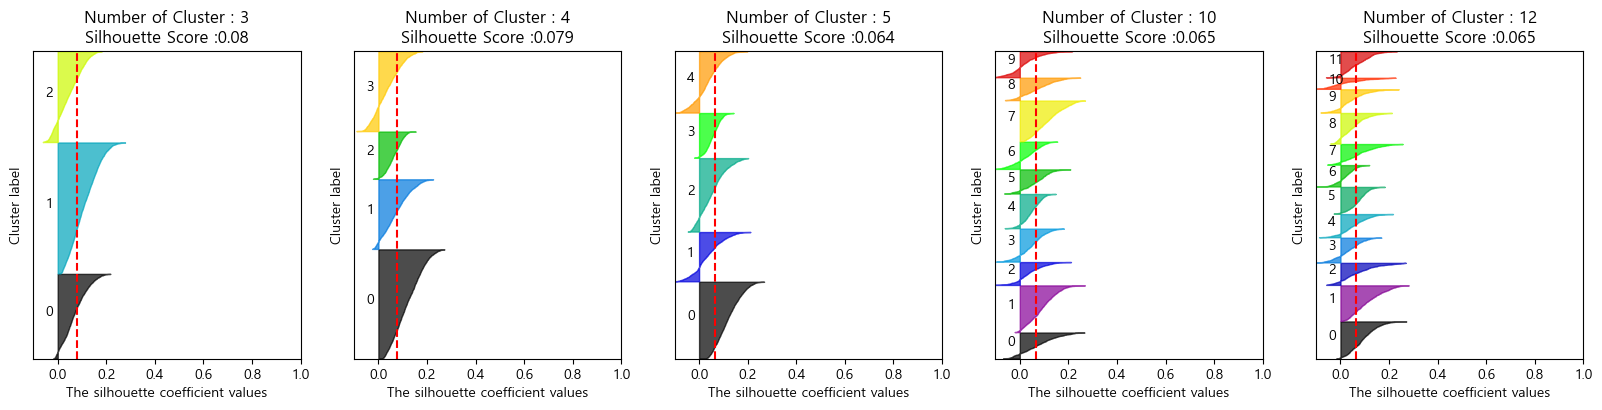

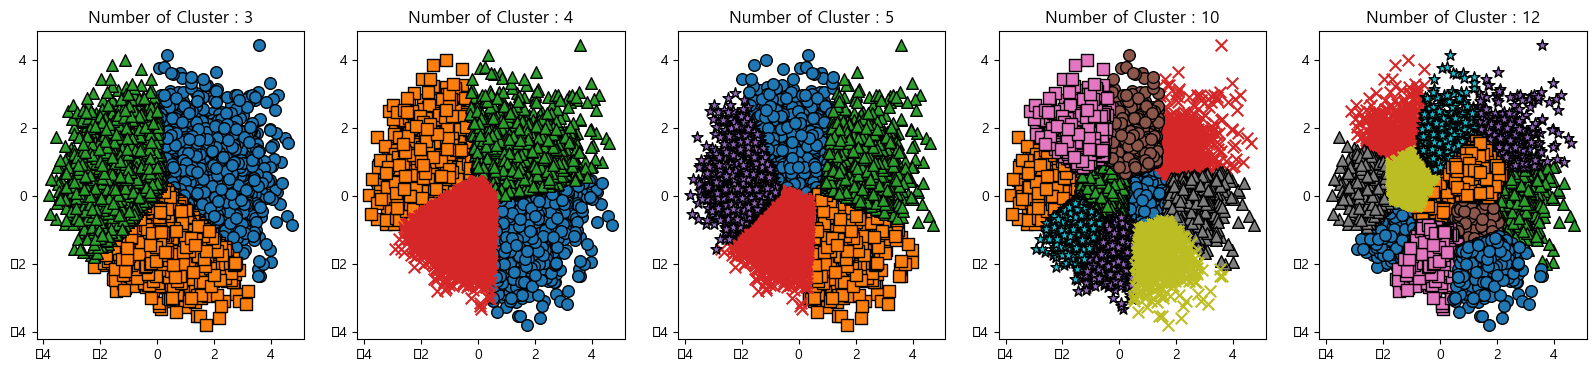

In [8]:
data = clusterdata[clusterdata["LABEL"] == 1]


# 이 부분은 기본 피쳐 부분입니다. 웬만하면 건드리시면 안 됩니다!!
Basic = data[["CAGR", "M", "ABS기타", "ABS가구", "ABS가공"]]
# 이 부분은 기본 피쳐 부분입니다. 웬만하면 건드리시면 안 됩니다!!


#이 부분 수정하시면 됩니다.
Additional = data[["성별","연령대","거주지역", "R", "F", "선호상품1", "선호상품2","기타변화", "가구변화","가공변화"]]
n_cluster = [3,4,5,10,12]
#이 부분 수정하시면 됩니다.




X_features = pd.concat([Basic, Additional], axis = 1)




X_features_scaled = StandardScaler().fit_transform(X_features)

# kmeans = KMeans(n_clusters = 3, random_state = 0)
# labels = kmeans.fit_predict(X_features_scaled)
# data["cluster_label"] = labels



visualize_silhouette(n_cluster, X_features_scaled)
visualize_kmeans_plot_multi(n_cluster, X_features_scaled)

In [9]:
kmeans = KMeans(n_clusters = 3, max_iter=500, random_state=0).fit(X_features)

X_features["cluster"] = kmeans.labels_

In [10]:
# X_features["고객번호"] = clusterdata[clusterdata["LABEL"] == 1]["고객번호"]

Basic = data[["cagr", "M", "ABS기타", "ABS가구", "ABS가공"]]
# 이 부분은 기본 피쳐 부분입니다. 웬만하면 건드리시면 안 됩니다!!


#이 부분 수정하시면 됩니다.
Additional = data[["성별","연령대","거주지역", "R", "F", "선호상품1", "선호상품2","기타변화", "가구변화","가공변화"]]
n_cluster = [3,4,5,10,12]
#이 부분 수정하시면 됩니다.




X_features = pd.concat([Basic, Additional], axis = 1)
X_features["cluster"] = kmeans.labels_

In [11]:
cluster0 = X_features[X_features["cluster"] == 0]
cluster1 = X_features[X_features["cluster"] == 1]
cluster2 = X_features[X_features["cluster"] == 2]

In [12]:
cluster0

,cagr,M,ABS기타,ABS가구,ABS가공,성별,연령대,거주지역,R,F,선호상품1,선호상품2,기타변화,가구변화,가공변화,cluster
17,-15.47,0,20,0,7,0,0,10,3,1,7,6,-6,0,1,0
36,-10.88,1,0,6,0,0,0,7,9,4,10,9,0,6,0,0
46,-10.71,4,4,7,13,0,0,7,8,6,6,0,-2,-7,-3,0
49,-9.64,3,14,5,9,0,0,7,2,6,11,6,0,-1,-1,0
62,-6.60,9,17,0,5,0,0,7,5,0,6,0,-7,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19354,-7.39,9,0,0,4,0,4,7,3,0,8,9,0,0,0,0
19358,-8.16,9,4,0,7,1,1,7,5,4,0,6,-4,0,-1,0
19359,-7.55,9,0,0,4,0,1,7,0,0,8,9,0,0,-2,0
19363,-7.02,5,14,0,2,0,3,10,7,2,8,9,-4,0,0,0


In [13]:
def make_pie(df, column, num = None):
    
    gender = {0 : "F", 1 : "M"}
    age = {0 : '노년층', 1 : '장년층', 2 : '중년층', 3 : '청년층', 4 : '학생층'}
    region = {0 : '강원', 1 : '경남', 2 : '경북', 3 : '광주', 4 : '대구', 5 : '대전', 6 : '부산', 7 : '서울', 8 : '세종', 9 : '울산',
            10 : '인천', 11 : '전남', 12 : '전북', 13 : '제주', 14 : '충남', 15 : '충북'}
    product = {0 : '가공', 1 : '가구', 2 : '교육', 3 : '기타', 4 : '디지털', 5 : '명품', 6 : '신선', 7 : '의류', 8 : '의약', 9 : '일상',
            10 : '전문스포츠', 11 : '패션잡화'}
    jehu = {0 : 'A', 1 : 'B', 2 : 'C', 3 : 'D'}
    
    
    count = df[column].value_counts().sort_index()
    index = list(count.index)
    value = list(count)
    
    label = []
    if column == "성별" :
        for i in index:
            label.append(gender[i])
        index = label
    elif column == "연령대" :
        for i in index:
            label.append(age[i])
        index = label
    elif column == "거주지역" :
        for i in index:
            label.append(region[i])
        index = label
    elif column in ["선호상품1", "선호상품2", "선호상품3"]:
        for i in index:
            label.append(product[i])
        index = label
    elif column == "선호제휴사" :
        for i in index:
            label.append(jehu[i])
        index = label
        
    if num:
        index = index[:num]
        value = value[:num]
    
    a = plt.pie(value, labels=index, autopct='%1.1f%%')
    plt.title(f"DataFrame {column} Cluster Pie Chart")

In [14]:
zerodata = clusterdata[clusterdata["LABEL"] == 0]
zerodata = zerodata[['cagr', 'M', 'ABS기타', 'ABS가구', 'ABS가공', '성별', '연령대', '거주지역', 'R', 'F',
       '선호상품1', '선호상품2', '기타변화', '가구변화', '가공변화']]
zerodata["cluster"] = 3

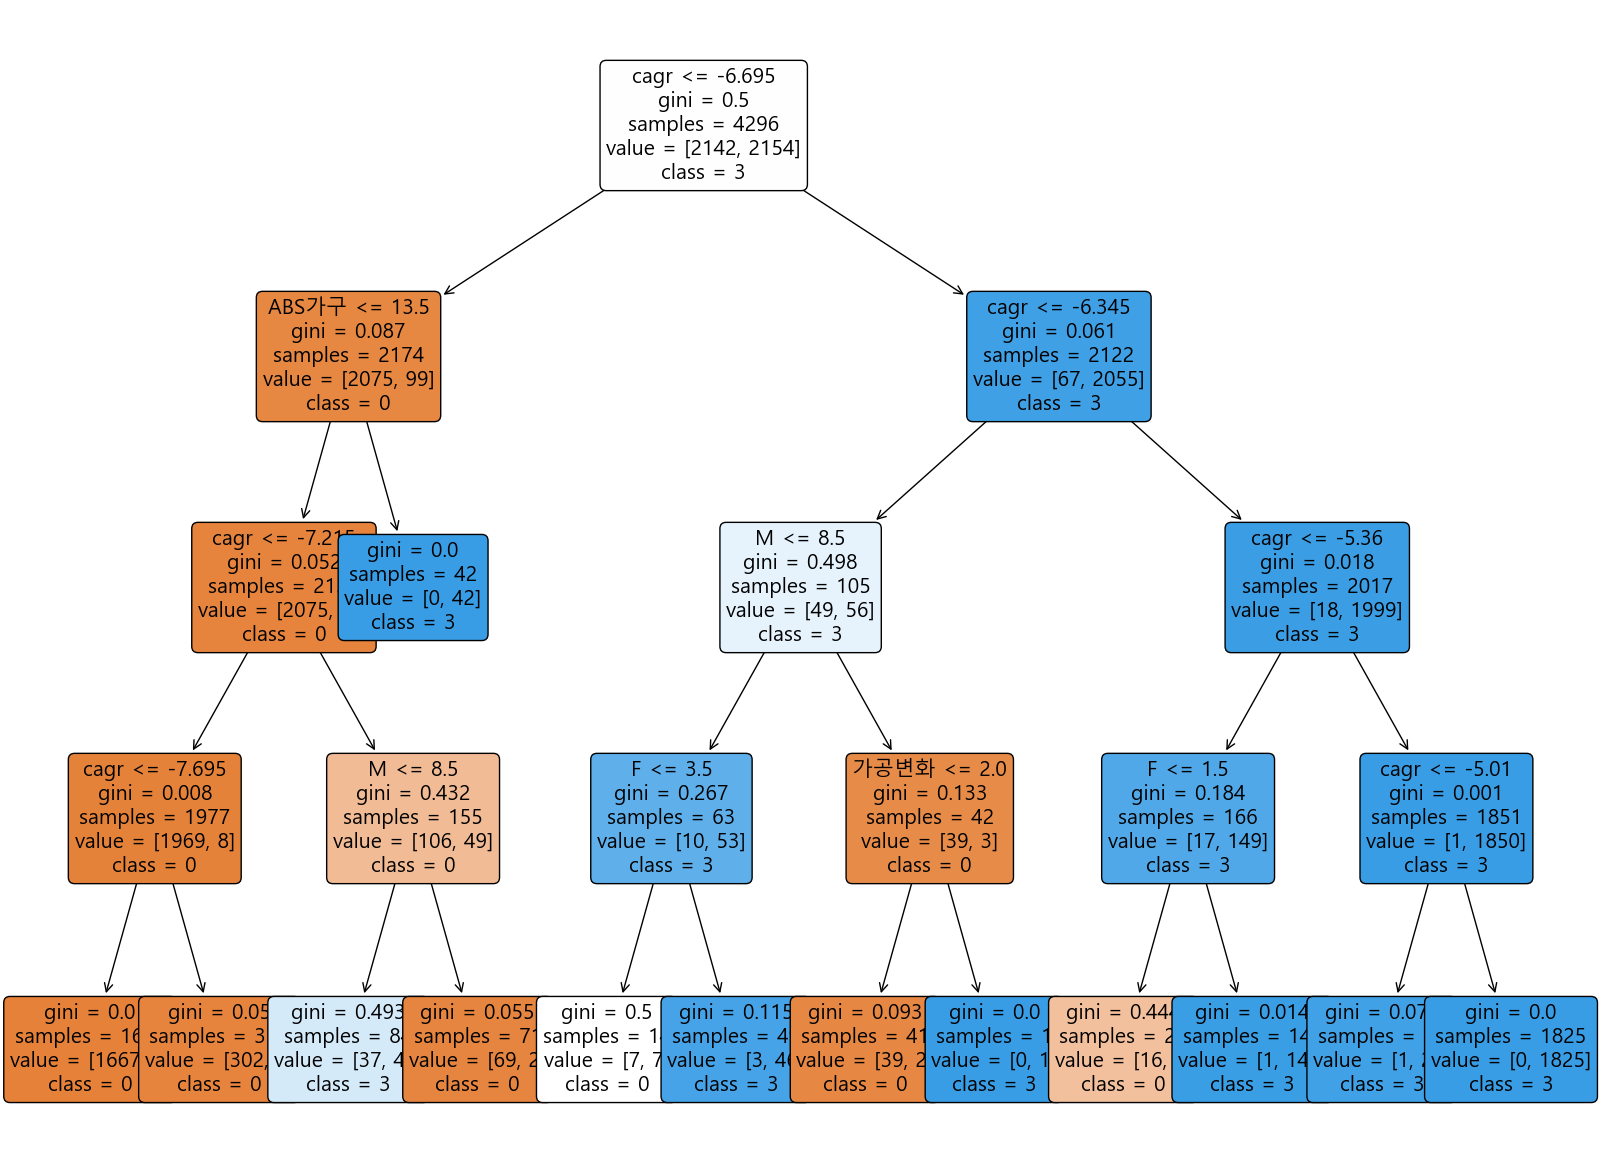

In [15]:
add0 = zerodata.sample(len(cluster0))
addon0 = pd.concat([cluster0, add0], axis = 0)
addon0 = addon0.reset_index().drop("index", axis = 1)

X_data = addon0.drop(["cluster"], axis = 1)
y_target = addon0["cluster"]

dt = DecisionTreeClassifier(max_depth = 4)

X_train, X_test, y_train, y_test = train_test_split(X_data, y_target, test_size = 0.2, random_state = 0)

dt.fit(X_train, y_train)

pred = dt.predict(X_test)

plt.figure(figsize=(20,15))
tree.plot_tree(dt, filled = True,
              feature_names = X_data.columns,
              class_names = y_target.unique().astype(str),
              rounded = True, fontsize = 15)

plt.show()

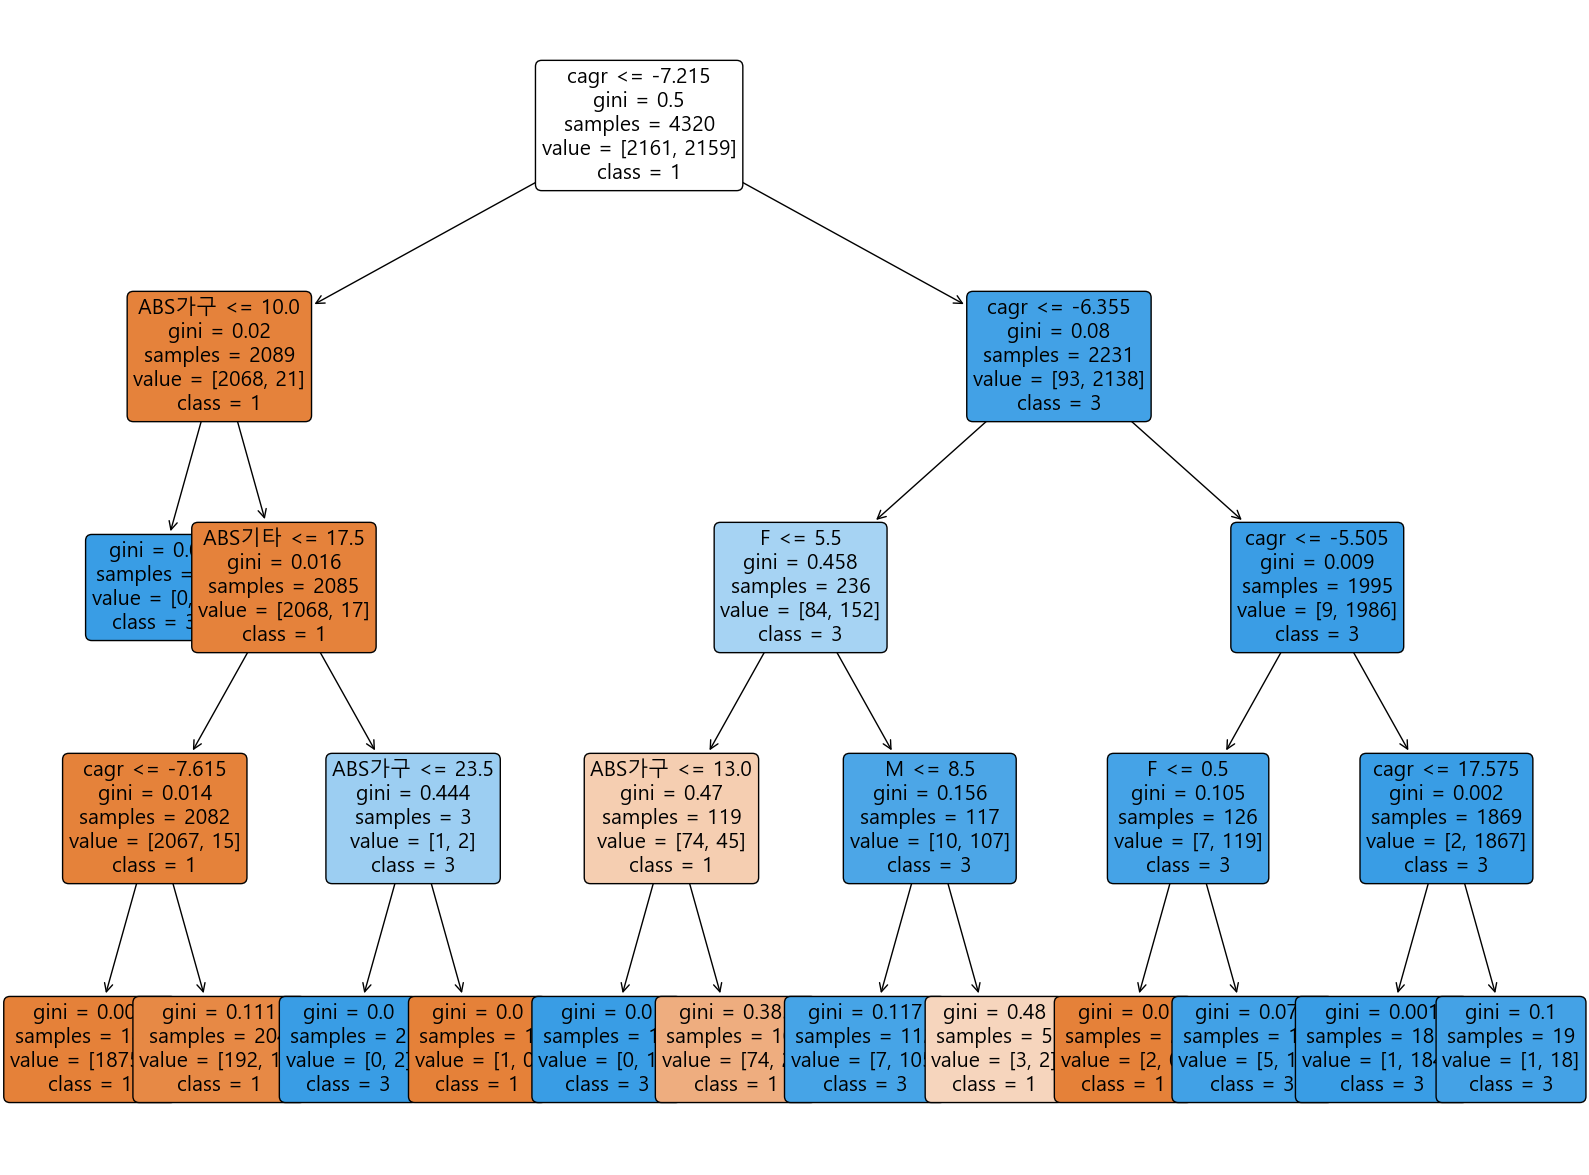

In [16]:
add1 = zerodata.sample(len(cluster1))
addon1 = pd.concat([cluster1, add1], axis = 0)
addon1 = addon1.reset_index().drop("index", axis = 1)

X_data = addon1.drop(["cluster"], axis = 1)
y_target = addon1["cluster"]

dt = DecisionTreeClassifier(max_depth = 4)

X_train, X_test, y_train, y_test = train_test_split(X_data, y_target, test_size = 0.2, random_state = 0)

dt.fit(X_train, y_train)

pred = dt.predict(X_test)

plt.figure(figsize=(20,15))
tree.plot_tree(dt, filled = True,
              feature_names = X_data.columns,
              class_names = y_target.unique().astype(str),
              rounded = True, fontsize = 15)

plt.show()

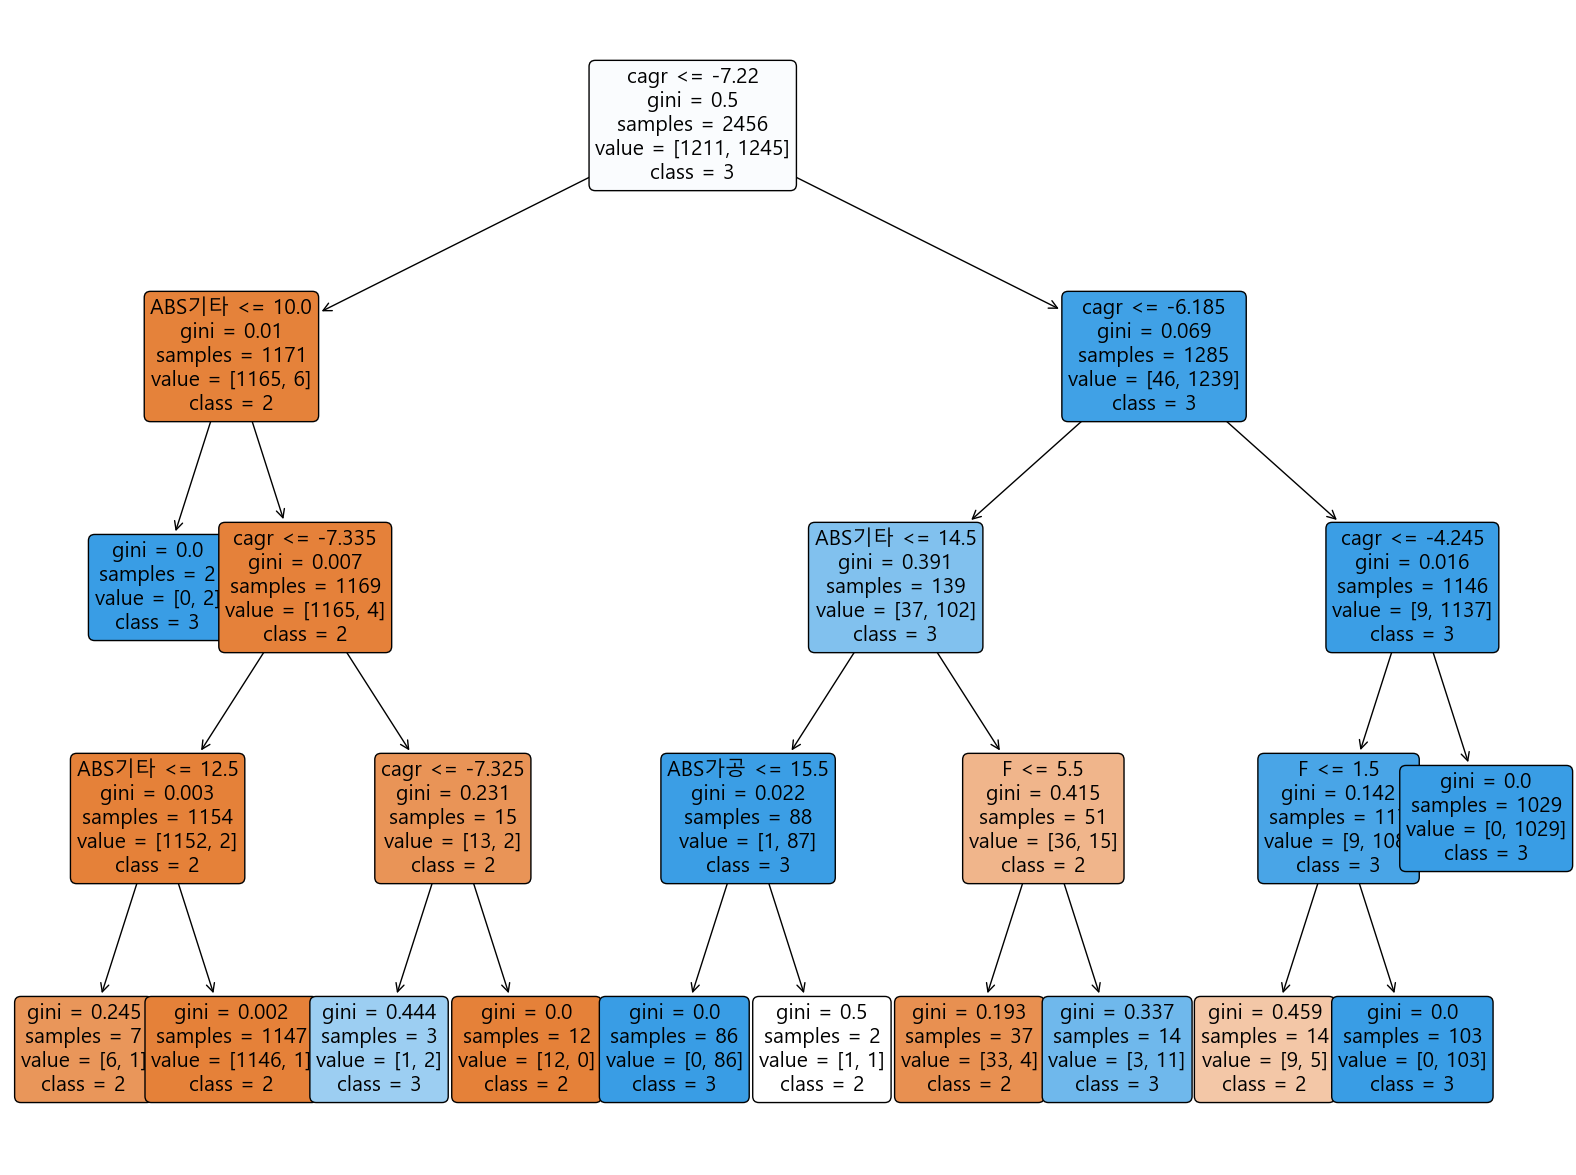

In [17]:
add2 = zerodata.sample(len(cluster2))
addon2 = pd.concat([cluster2, add2], axis = 0)
addon2 = addon2.reset_index().drop("index", axis = 1)

X_data = addon2.drop(["cluster"], axis = 1)
y_target = addon2["cluster"]

dt = DecisionTreeClassifier(max_depth = 4)

X_train, X_test, y_train, y_test = train_test_split(X_data, y_target, test_size = 0.2, random_state = 0)

dt.fit(X_train, y_train)

pred = dt.predict(X_test)

plt.figure(figsize=(20,15))
tree.plot_tree(dt, filled = True,
              feature_names = X_data.columns,
              class_names = y_target.unique().astype(str),
              rounded = True, fontsize = 15)

plt.show()

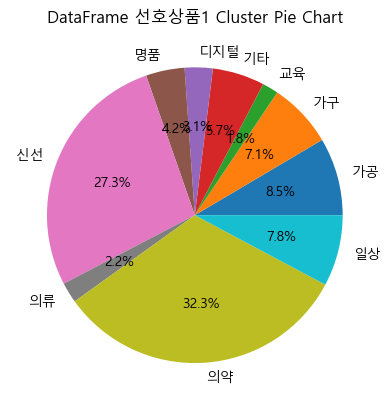

In [18]:
make_pie(X_features, "선호상품1", 10)

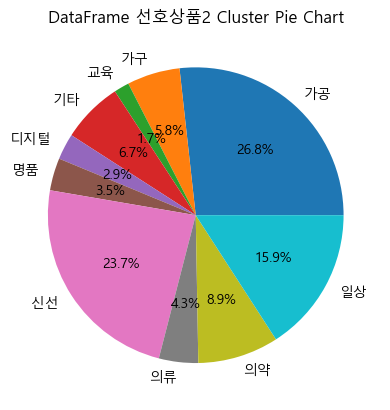

In [19]:
make_pie(X_features, "선호상품2", 10)

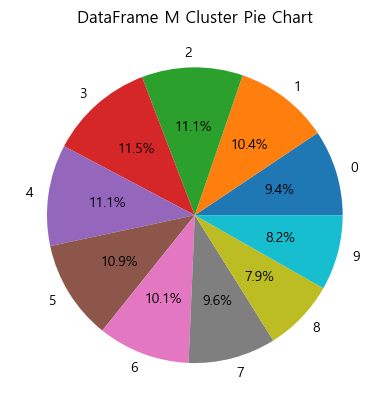

In [20]:
make_pie(X_features, "M", 10)

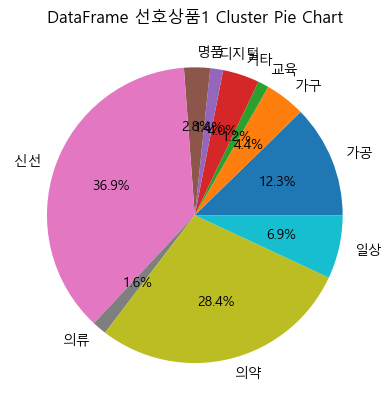

In [21]:
make_pie(cluster0, "선호상품1",10)

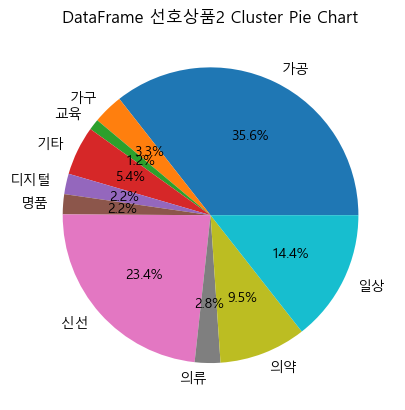

In [22]:
make_pie(cluster0, "선호상품2", 10)

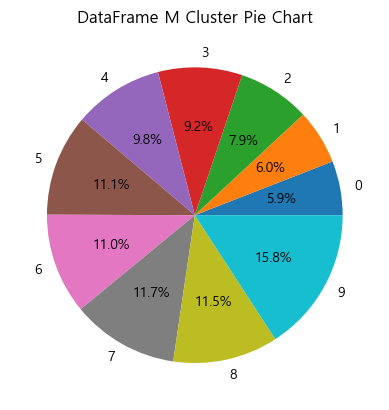

In [23]:
make_pie(cluster0, "M", 10)

In [24]:
cluster0.columns

Index(['cagr', 'M', 'ABS기타', 'ABS가구', 'ABS가공', '성별', '연령대', '거주지역', 'R', 'F',
       '선호상품1', '선호상품2', '기타변화', '가구변화', '가공변화', 'cluster'],
      dtype='object')

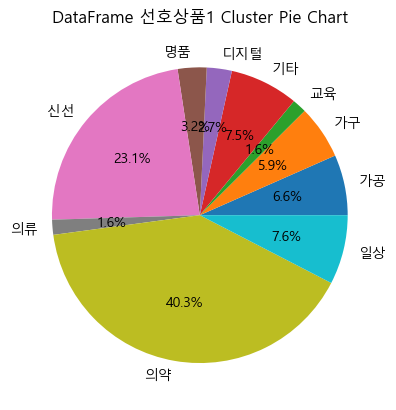

In [25]:
make_pie(cluster1, "선호상품1",10)

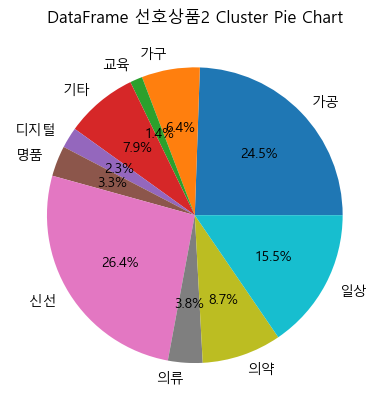

In [26]:
make_pie(cluster1, "선호상품2", 10)

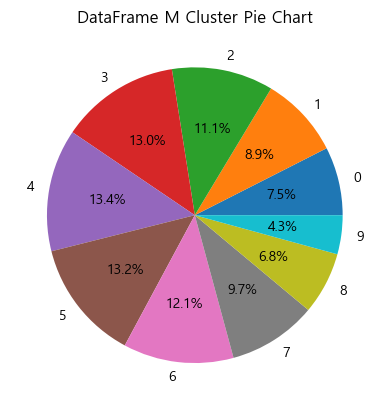

In [27]:
make_pie(cluster1, "M", 10)

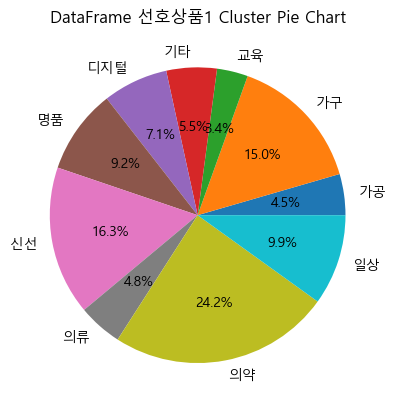

In [28]:
make_pie(cluster2, "선호상품1",10)

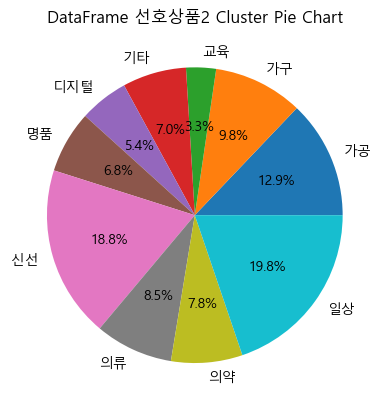

In [29]:
make_pie(cluster2, "선호상품2", 10)

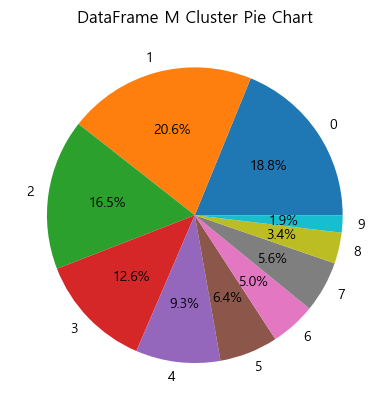

In [30]:
make_pie(cluster2, "M", 10)

In [31]:
analyzedata = pd.read_pickle("dataSet/analyzedata.pkl")

In [32]:
cl0 = analyzedata[analyzedata["cluster"] == 0]
cl1 = analyzedata[analyzedata["cluster"] == 1]
cl2 = analyzedata[analyzedata["cluster"] == 2]

Text(0.5, 1.0, '군집 별 총 매출액')

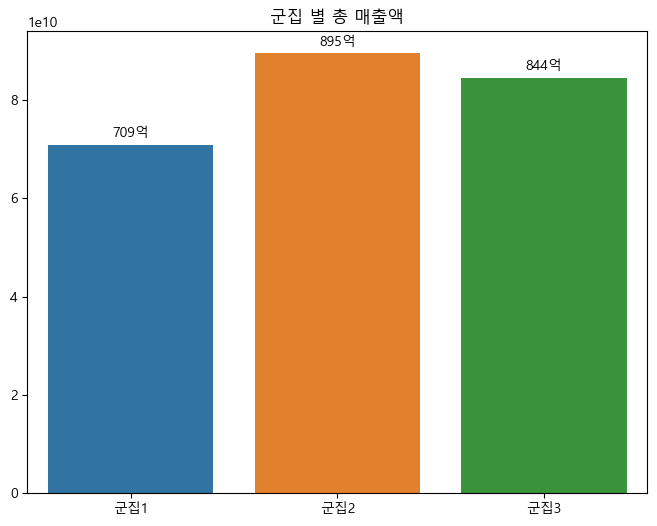

In [33]:
plt.figure(figsize=(8, 6))

x_labels = ["군집1", "군집2", "군집3"]
y_values = [cl0["구매 총액"].sum(), cl1["구매 총액"].sum(), cl2["구매 총액"].sum()]

ax = sns.barplot(x=x_labels, y=y_values)

# 각 막대 위에 숫자 표기
for i, v in enumerate(y_values):
    v_formatted = f'{v//100000000}억'
    ax.text(i, v + 1000000000, v_formatted, ha='center', va='bottom')

plt.title("군집 별 총 매출액")

In [34]:
cl0[["최근성","행동 빈도","구매 총액","평균구매액"]].describe()

,최근성,행동 빈도,구매 총액,평균구매액
count,2685.000000,2685.000000,2.685000e+03,2.685000e+03
mean,6.104283,1591.868901,2.641115e+07,2.584746e+04
std,20.238746,883.369670,5.502865e+07,7.250926e+04
min,1.000000,12.000000,2.500000e+05,1.770220e+03
25%,1.000000,904.000000,9.413148e+06,5.703330e+03
50%,2.000000,1457.000000,1.424197e+07,9.025750e+03
75%,4.000000,2131.000000,2.546161e+07,2.212566e+04
max,381.000000,10290.000000,2.134909e+09,2.538536e+06


In [35]:
cl1[["최근성","행동 빈도","구매 총액","평균구매액"]].describe()

,최근성,행동 빈도,구매 총액,평균구매액
count,2700.000000,2700.000000,2.700000e+03,2.700000e+03
mean,3.845926,1568.478889,3.315779e+07,3.100452e+04
std,8.356673,762.171254,5.971784e+07,6.467775e+04
min,1.000000,36.000000,1.157340e+06,3.113130e+03
25%,1.000000,970.000000,1.272745e+07,7.311148e+03
50%,2.000000,1451.000000,1.822562e+07,1.143686e+04
75%,4.000000,2035.500000,3.429458e+07,2.984232e+04
max,182.000000,5389.000000,1.721008e+09,1.301822e+06


In [36]:
cl2[["최근성","행동 빈도","구매 총액","평균구매액"]].describe()

,최근성,행동 빈도,구매 총액,평균구매액
count,1535.000000,1535.000000,1.535000e+03,1.535000e+03
mean,5.045603,1122.763518,5.501513e+07,6.327951e+04
std,11.457501,573.638246,7.456962e+07,1.017277e+05
min,1.000000,114.000000,3.494875e+06,3.586770e+03
25%,1.000000,727.000000,1.848414e+07,1.522292e+04
50%,2.000000,954.000000,3.748598e+07,3.905212e+04
75%,5.000000,1376.000000,6.729573e+07,7.813182e+04
max,278.000000,5955.000000,1.489527e+09,2.429897e+06


Text(0.5, 1.0, '군집 별 평균 방문 빈도')

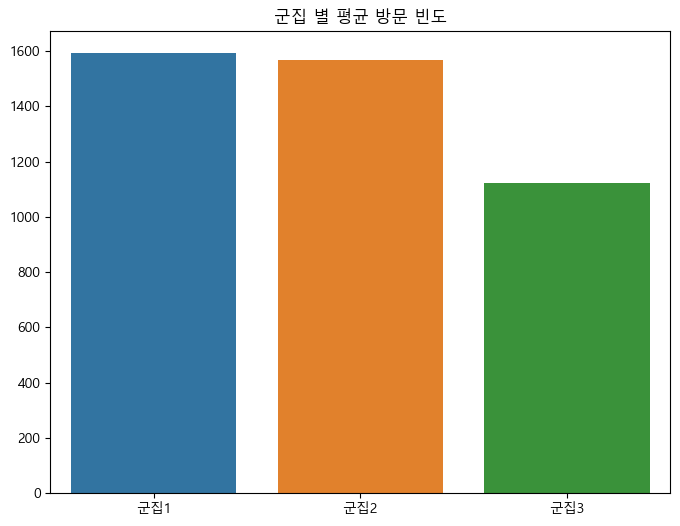

In [37]:
plt.figure(figsize=(8, 6))

x_labels = ["군집1", "군집2", "군집3"]
y_values = [cl0["행동 빈도"].mean(), cl1["행동 빈도"].mean(), cl2["행동 빈도"].mean()]

ax = sns.barplot(x=x_labels, y=y_values)


plt.title("군집 별 평균 방문 빈도")

Text(0.5, 1.0, '군집 별 평균 총 구매액')

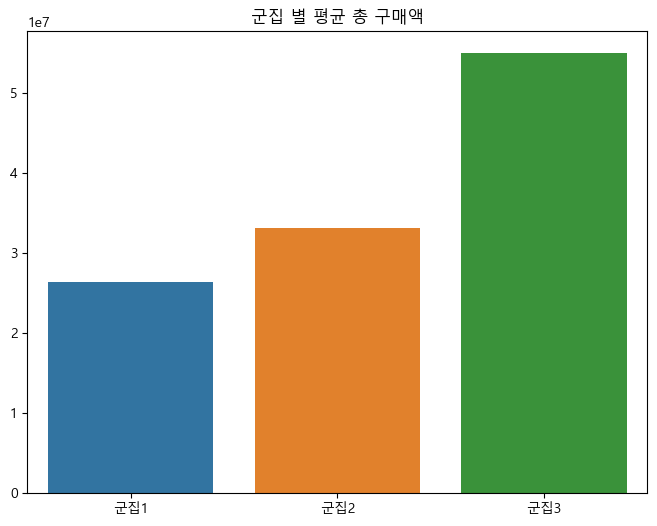

In [38]:
plt.figure(figsize=(8, 6))

x_labels = ["군집1", "군집2", "군집3"]
y_values = [cl0["구매 총액"].mean(), cl1["구매 총액"].mean(), cl2["구매 총액"].mean()]

ax = sns.barplot(x=x_labels, y=y_values)


plt.title("군집 별 평균 총 구매액")

Text(0.5, 1.0, '군집 별 1회 평균 구매액')

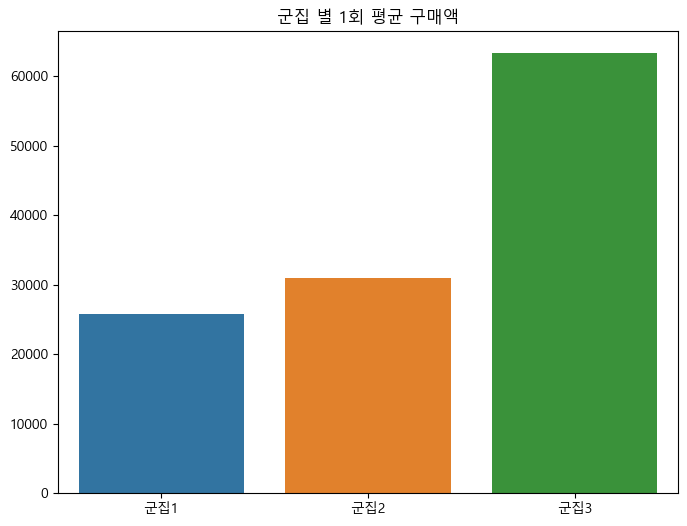

In [39]:
plt.figure(figsize=(8, 6))

x_labels = ["군집1", "군집2", "군집3"]
y_values = [cl0["평균구매액"].mean(), cl1["평균구매액"].mean(), cl2["평균구매액"].mean()]

ax = sns.barplot(x=x_labels, y=y_values)


plt.title("군집 별 1회 평균 구매액")

In [40]:
def make_pie2(df, column, num = None):
    
    count = df[column].value_counts().sort_index()
    index = list(count.index)
    value = list(count)
    
    if num:
        index = index[:num]
        value = value[:num]
    
    a = plt.pie(value, labels=index, autopct='%1.1f%%')
    plt.title(f"DataFrame {column} Cluster Pie Chart")

In [41]:
print(len(cl0),len(cl1),len(cl2))

2685 2700 1535


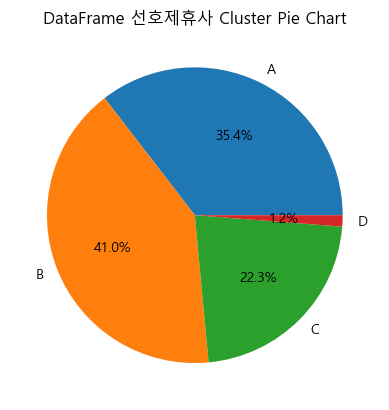

In [42]:
make_pie2(customerdata, "선호제휴사")

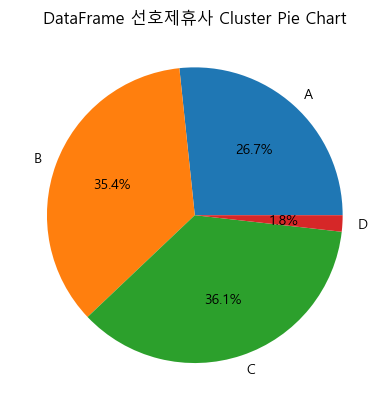

In [43]:
make_pie2(cl0, "선호제휴사")

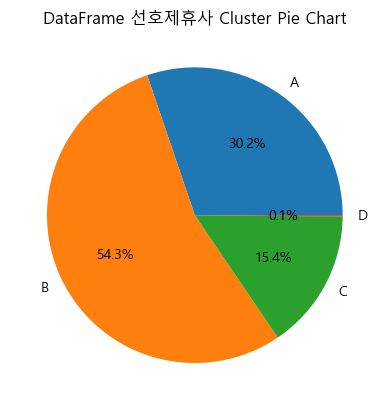

In [44]:
make_pie2(cl1, "선호제휴사")

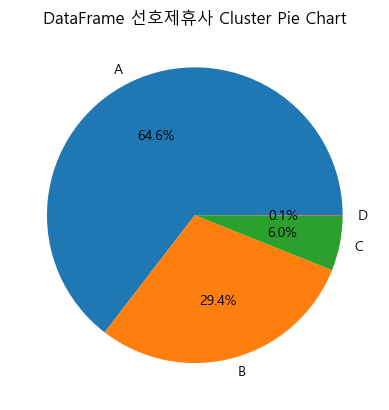

In [45]:
make_pie2(cl2, "선호제휴사")

In [47]:
cl2["고객번호"]

,고객번호,고객번호
1,00002,00002
3,00004,00004
13,00014,00014
20,00021,00021
26,00027,00027
...,...,...
19311,19312,19312
19323,19324,19324
19329,19330,19330
19333,19334,19334
